In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import batting_stats,pitching_stats,playerid_lookup

In [2]:
teams = pd.read_csv('mlb_teams.csv')

# load fangraphs batting and pitching stats
db = pd.read_csv('stats/fg_batting2014-2022.csv')
print(len(db))

dp = pd.read_csv('stats/fg_pitching2014-2022.csv')
print(len(dp))

8140
6954


## Get/Load the salary data

In [3]:
pay = pd.read_csv('salaries/2015-2023_active_salaries.csv')
pay['log_pay'] = np.log10(pay['pay'])


# adjust pay to 2023 due to inflation (https://www.usinflationcalculator.com/)
infl = pd.read_csv('inflation2023.csv')
infl['Season'] = infl['year']

pay = pd.merge(pay,infl,  on=['year','Season'])
pay['pay_adj'] = pay['pay']*pay['adj']
pay['log_pay_adj'] = np.log10(pay['pay_adj'])

/home/rachel/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rachel/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
pay = pd.read_csv('salaries/2015-2023_active_salaries_adj_fgids.csv')

In [5]:
# how many "bad" rows are there
len(pay[pay['pay']==0])

23

### Initial Exploration

<AxesSubplot:xlabel='age', ylabel='log_pay_adj'>

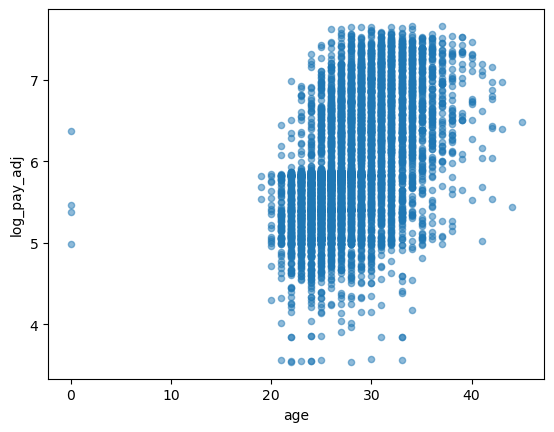

In [6]:
pay.plot.scatter(x="age", y="log_pay_adj", alpha=0.5)

There are 4 entries with and age of zero, but we'll worry about that later

Text(0, 0.5, 'log Season Salaries (adjusted for inflation 2023)')

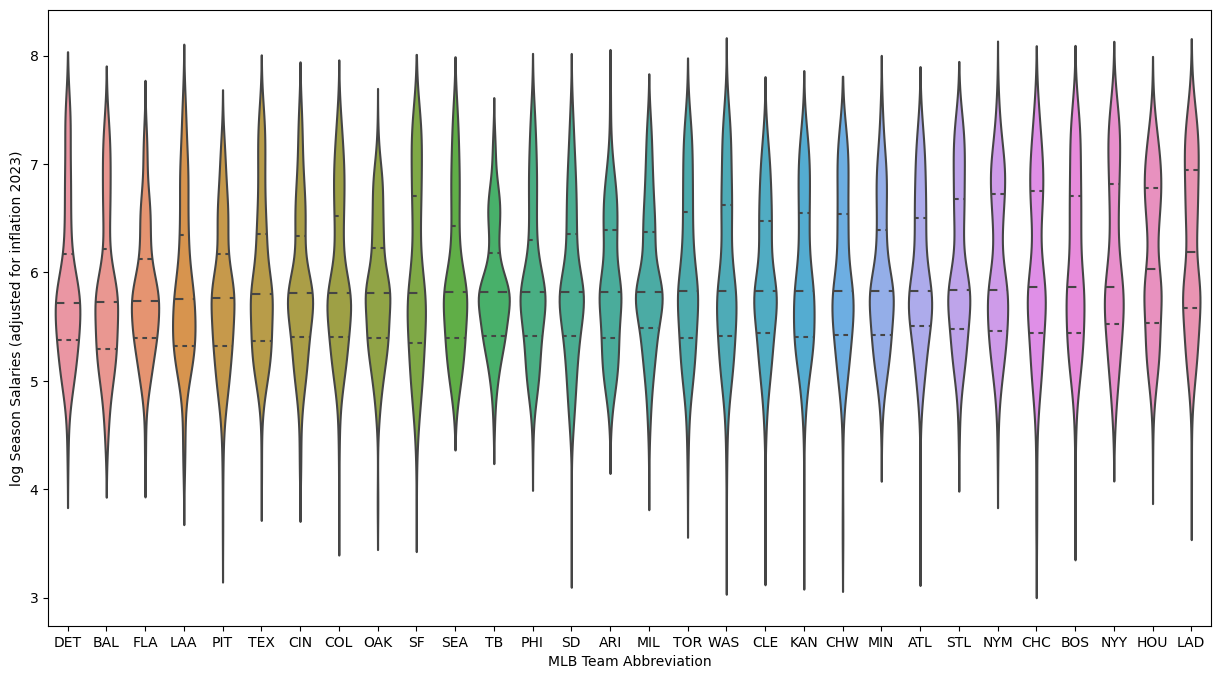

In [7]:
# what is the dependence on team? How signifigant is it?
fig,ax =plt.subplots(1,1,figsize=(15,8))
df_temp = pay[pay['pay']>0] # no nans

# get the median values and sort by them
medians = df_temp.groupby('team_abbrev')['log_pay_adj'].median()
sorting = medians.sort_values().index

sns.violinplot(data=df_temp,
               x = 'team_abbrev',
               y = 'log_pay_adj', 
               ax=ax,
               order=sorting,
               inner='quart')
ax.set_xlabel('MLB Team Abbreviation')
ax.set_ylabel('log Season Salaries (adjusted for inflation 2023)')

Text(0, 0.5, 'log Season Salaries (adjusted for inflation 2023)')

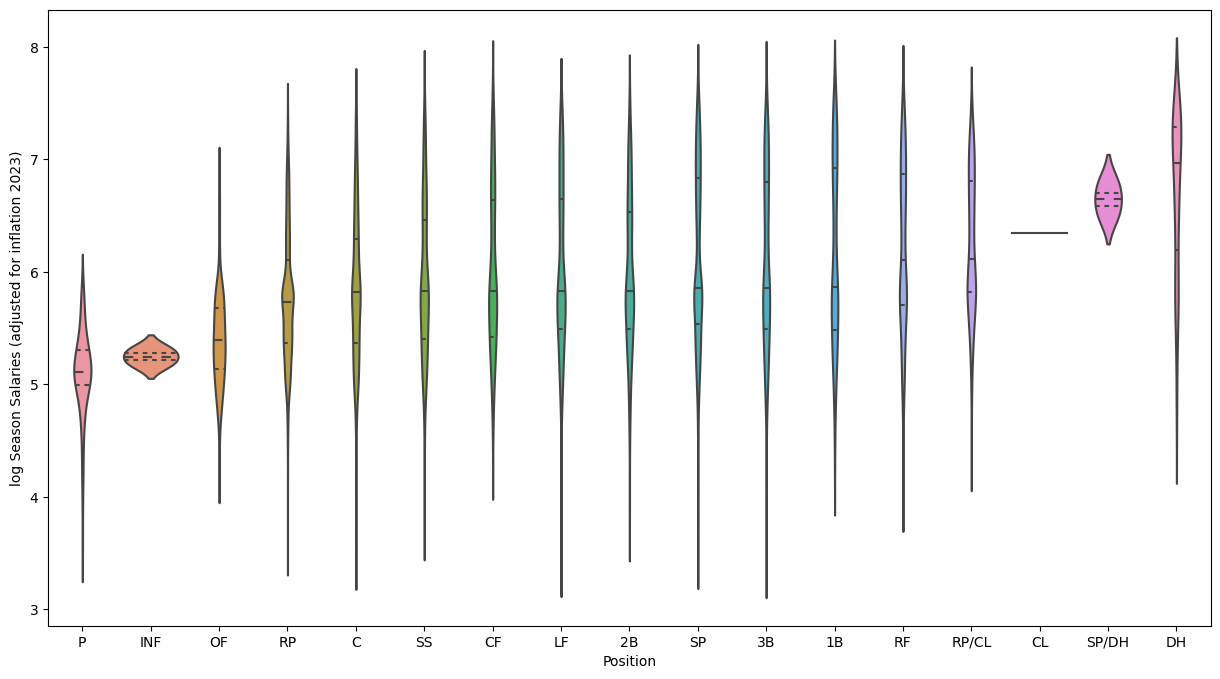

In [8]:
# let's make the same plot but by position
fig,ax =plt.subplots(1,1,figsize=(15,8))
df_temp = pay[pay['pay']>0] # no nans

# get the median values and sort by them
medians = df_temp.groupby('position')['log_pay_adj'].median()
sorting = medians.sort_values().index

sns.violinplot(data=df_temp,
               x = 'position',
               y = 'log_pay_adj', 
               ax=ax,
               order=sorting,
               inner='quart')
ax.set_xlabel('Position')
ax.set_ylabel('log Season Salaries (adjusted for inflation 2023)')

---

## Add Stats to the Table
Let's assume the pay for a given year is based on the previous season's performance

In [34]:
pay['Season_prev'] = pay['Season']-1
pay = pay[pay['Season_prev']>2014]

# positions are important so let's add them as catagoricals 
result = pd.concat([pay, pd.get_dummies(pay['position'])], axis=1)

result.loc[:,'RP'] = result.loc[:,'RP'] + result.loc[:,'RP/CL']
result.loc[:,'CL'] = result.loc[:,'CL'] + result.loc[:,'RP/CL']

result.loc[:,'SP'] = result.loc[:,'SP'] + result.loc[:,'SP/DH']
result.loc[:,'DH'] = result.loc[:,'DH'] + result.loc[:,'SP/DH']

# let's make a column for whether a player is a pitcher (has pitching stats) or not
is_pitch = np.logical_or.reduce(result[['P','SP','RP','CL']].values.astype(bool), axis=1)
# not all pitchers are batters though, so we need a column to mark whether the player has batting stats
is_bat = np.logical_or.reduce(result[['INF','OF','C','SS','CF','LF','RF','1B','2B','3B','DH']].values.astype(bool), axis=1)

# make sure all the players are accounted for
print(np.sum(~np.logical_or(is_pitch,is_bat)),' players missing')

result['is_pitch'] = is_pitch.astype(int)
result['is_bat'] = is_bat.astype(int)

# alright, I'm removing these dummy columns
dummies = ['INF','OF','C','SS','CF','LF','RF','1B','2B','3B','DH']+['P','SP','RP','CL']
result = result[result.columns[~np.isin(result.columns,dummies)]]

0  players missing


Note: While it isn't necessary for this analysis to have catagorical variables for every single position since we're just using batting and pitching stats, it's good to have them just in case

In [35]:
# create copies of the pitcher and batter stat dfs
db_new = db.loc[:, np.logical_and(db.columns != 'Season', db.columns != 'IDfg')].copy()
db_new['Season_prev'] = db.loc[:,'Season'].values
db_new['fgid'] = db.loc[:,'IDfg'].values


dp_new = dp.loc[:, np.logical_and(dp.columns != 'Season', dp.columns != 'IDfg')].copy()
dp_new['Season_prev'] = dp.loc[:,'Season'].values
dp_new['fgid'] = dp.loc[:,'IDfg'].values

# there are some column names that are in both the batting and pitching tables
mapcol_p = {colname:'p_'+colname for colname in list(dp.columns)[2:] if colname in list(db.columns)}
mapcol_b = {colname:'b_'+colname for colname in list(db.columns)[2:] if colname in list(dp.columns)}

dp_new = dp_new.rename(columns=mapcol_p)
db_new = db_new.rename(columns=mapcol_b)

# merge
pitchers = pd.merge(result[is_pitch],dp_new, on=['Season_prev','fgid'], how='left')
batters = pd.merge(result[is_bat],db_new, on=['Season_prev','fgid'], how='left')

print(len(pitchers), len(batters),len(pitchers)+len(batters) )
print('1B_y' in batters)
# need to fill those naans with a fill value
#result = result.fillna(-9999)

3546 3246 6792
False


In [38]:
# I'm saving these so I can use it directly
pitchers.to_csv('stats_and_pay_pitchers.csv', index=False)
batters.to_csv('stats_and_pay_batters.csv', index=False)

<AxesSubplot:xlabel='age', ylabel='b_Age'>

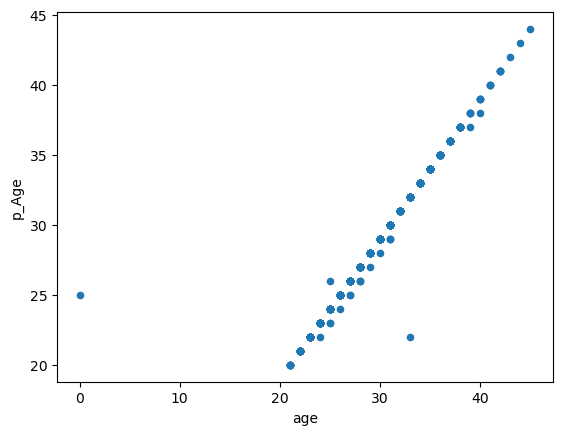

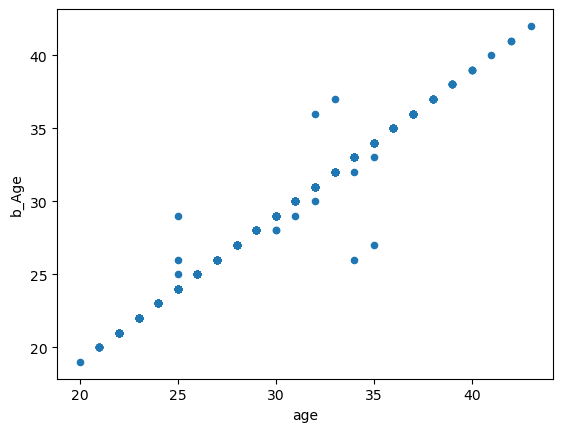

In [36]:
# plot the ages
df_temp = pitchers[pitchers['pay_adj']>0]
df_temp.plot.scatter(x='age',y='p_Age')

df_temp = batters[batters['pay_adj']>0]
df_temp.plot.scatter(x='age',y='b_Age')
# use 'p_Age' + 1  or 'b_Age'+1 as age

Now let's just look at pitchers only to find correlations

In [12]:
# what initially seem like the stats that influcence pay the most for pitchers?
pitch_corr_df = pitchers.corr(numeric_only=True) # get the pearson-r correlation matrix

pay_corr_sort = np.abs(pitch_corr_df['log_pay_adj']).sort_values()[::-1].dropna() # sort by the columns that correlate the most with pay
nvals_in_cols = np.array([np.sum(~np.isnan(pitchers[col].values)) for col in pay_corr_sort.index])

pay_corr_sort[np.logical_and(nvals_in_cols>100, pay_corr_sort<1.0)].iloc[:50]

log_pay      0.999304
pay          0.759417
pay_adj      0.758381
p_+WPA       0.566196
Start-IP     0.542335
age          0.538780
p_SO         0.533826
p_-WPA       0.512991
p_RAR        0.511025
p_WAR        0.508348
IP           0.507773
p_Age        0.506878
p_Strikes    0.504516
Starting     0.504247
p_Pitches    0.496809
W            0.496412
TBF          0.494731
RA9-WAR      0.484037
p_Balls      0.478261
p_Events     0.471669
p_GB         0.459502
p_FB         0.454853
p_H          0.451874
p_LD         0.451645
RS           0.451471
p_HardHit    0.444190
GS           0.420731
p_IFH        0.419611
p_Barrels    0.409861
p_IFFB       0.406266
p_BB         0.399278
p_R          0.397104
p_HR         0.396214
ER           0.393804
L            0.392306
inLI         0.392254
Relieving    0.379928
p_BU         0.363644
p_pLI        0.356980
botERA       0.349278
botOvr       0.345877
botxRV100    0.343043
Location+    0.335311
kwERA        0.329969
xFIP         0.327953
Pitching+ 

This is all well and good, but there quite a few degeneracies that we should be aware of so that we aren't using too many columns that all mean the same thing. Obviously all of the salary values are going to correlate (pay, log_pay, pay_adj, log_pay_adj) and the player's age is in three different columns technically, but there are also some degeneracies in the pitching stats. For instance, there's a positive correlation between pay and the number of walks (W). Why would that make sense? Teams certainly don't want value our pitchers higher because they're walking more batters, but the raw number of walks is going to natually scale with the number of pitches thrown (p_Pitches).

<AxesSubplot:xlabel='p_Pitches', ylabel='log_pay_adj'>

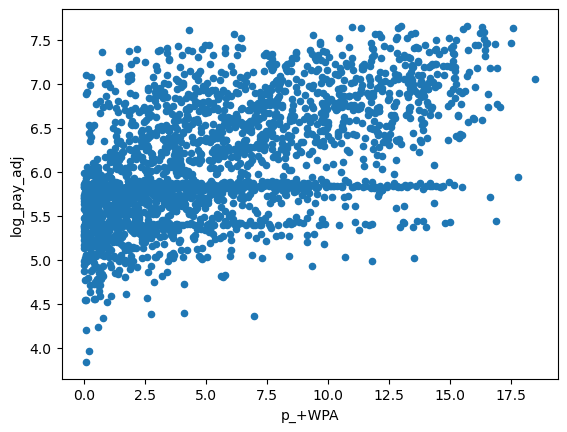

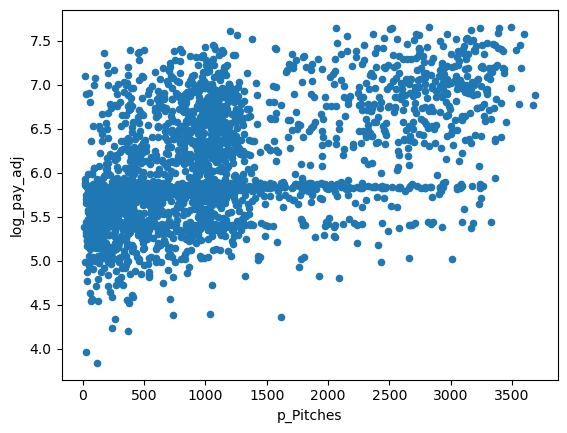

In [13]:
# visualize
df_temp = pitchers[pitchers['pay_adj']>0]
df_temp.plot.scatter(x='p_+WPA',y='log_pay_adj')
df_temp.plot.scatter(x='p_Pitches',y='log_pay_adj')

In [14]:
# what initially seem like the stats that influcence pay the most for batters?
bat_corr_df = batters.corr(numeric_only=True) # get the pearson-r correlation matrix

pay_corr_sort = np.abs(bat_corr_df['log_pay_adj']).sort_values()[::-1].dropna() # sort by the columns that correlate the most with pay
nvals_in_cols = np.array([np.sum(~np.isnan(batters[col].values)) for col in pay_corr_sort.index])

pay_corr_sort[np.logical_and(nvals_in_cols>100, pay_corr_sort<1.0)].iloc[:50]

log_pay      0.999362
pay_adj      0.793118
pay          0.788927
b_HardHit    0.593399
b_+WPA       0.588744
b_Balls      0.581863
wRC          0.581289
PA           0.579321
Rep          0.578915
b_Pitches    0.576576
b_Events     0.575730
RBI          0.574242
b_H          0.571153
b_FB         0.571140
AB           0.570826
b_R          0.567557
b_Strikes    0.567452
b_-WPA       0.562892
b_LD         0.559903
b_BB         0.549108
1B_y         0.542708
b_GB         0.541705
2B_y         0.536004
b_G          0.521735
GDP          0.515481
age          0.513905
b_HR         0.505872
b_Barrels    0.505264
L-WAR        0.479284
b_WAR        0.472367
b_RAR        0.470355
b_SO         0.455101
b_Age        0.449029
SF           0.447777
b_IFFB       0.408897
Lg           0.402770
b_IFH        0.402374
b_IBB        0.380509
wRAA         0.368925
b_RE24       0.366043
b_REW        0.365742
b_wFB        0.358379
b_WPA/LI     0.353760
b_maxEV      0.344473
Bat          0.336699
OPS       

<AxesSubplot:xlabel='b_HardHit', ylabel='log_pay_adj'>

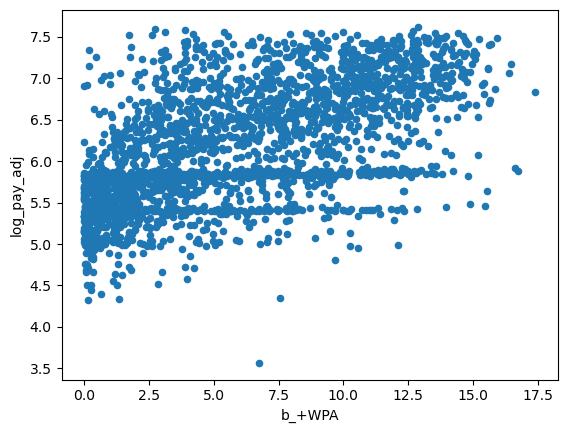

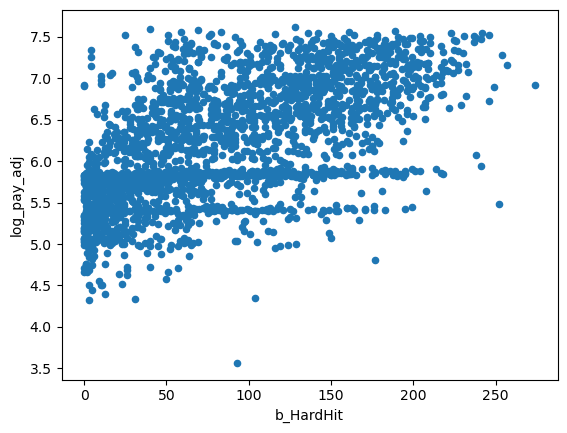

In [15]:
# visualize
df_temp = batters[batters['pay_adj']>0]
df_temp.plot.scatter(x='b_+WPA',y='log_pay_adj')
df_temp.plot.scatter(x='b_HardHit',y='log_pay_adj')